In [1]:
import aocd
import numpy as np
from time import sleep
from collections import defaultdict
from itertools import permutations
import matplotlib.pyplot as plt

data = list([int(d) for d in aocd.get_data(day=11).split(",")])
print(data)

[3, 8, 1005, 8, 302, 1106, 0, 11, 0, 0, 0, 104, 1, 104, 0, 3, 8, 102, -1, 8, 10, 101, 1, 10, 10, 4, 10, 1008, 8, 0, 10, 4, 10, 101, 0, 8, 29, 1006, 0, 78, 2, 1007, 9, 10, 3, 8, 1002, 8, -1, 10, 1001, 10, 1, 10, 4, 10, 1008, 8, 1, 10, 4, 10, 1002, 8, 1, 58, 1006, 0, 7, 3, 8, 1002, 8, -1, 10, 101, 1, 10, 10, 4, 10, 1008, 8, 0, 10, 4, 10, 1002, 8, 1, 83, 2, 1009, 4, 10, 3, 8, 102, -1, 8, 10, 1001, 10, 1, 10, 4, 10, 1008, 8, 0, 10, 4, 10, 1002, 8, 1, 109, 1, 106, 11, 10, 1006, 0, 16, 3, 8, 1002, 8, -1, 10, 1001, 10, 1, 10, 4, 10, 1008, 8, 1, 10, 4, 10, 102, 1, 8, 138, 2, 108, 0, 10, 1, 101, 14, 10, 1, 1109, 1, 10, 3, 8, 1002, 8, -1, 10, 101, 1, 10, 10, 4, 10, 1008, 8, 0, 10, 4, 10, 102, 1, 8, 172, 2, 3, 10, 10, 1006, 0, 49, 3, 8, 1002, 8, -1, 10, 101, 1, 10, 10, 4, 10, 1008, 8, 1, 10, 4, 10, 1001, 8, 0, 201, 1006, 0, 28, 2, 3, 15, 10, 2, 109, 12, 10, 3, 8, 1002, 8, -1, 10, 1001, 10, 1, 10, 4, 10, 108, 0, 8, 10, 4, 10, 1001, 8, 0, 233, 3, 8, 102, -1, 8, 10, 1001, 10, 1, 10, 4, 10, 108, 1, 8

In [2]:
IN_SIZE = {1: 4, 2: 4, 3: 2, 4: 2, 5: 3, 6: 3, 7: 4, 8: 4, 9: 2, 99: 1}
IN_NAME =  {1: "add", 2: "mul", 3: "rd", 4: "prnt", 5: "jnz", 6: "jz", 
            7: "lt", 8: "eq", 9: "bas", 99: "ret"}
EXT_MEM = 1000

class Process():  # wrapper for generator
    def __init__(self, data, inp=[], dbg=False): 
        self.d = data[:]+[0]*EXT_MEM  # copy + extend memory
        self.done = False
        self.pg = self.process_gen(dbg=dbg)
        self.inp = inp
        self.base = 0
        
    def process(self, inp=[]):
        self.inp = inp
        return next(self.pg)
    
    def proc_data(self, inp): 
        self.process(inp)
        return self.d[:-EXT_MEM]
    
    def parse_ins(self, ptr, dbg):
        param = [0, 0, 0]
        ins = self.d[ptr]%100
        modes = [self.d[ptr]//10**e%10 for e in range(2,5)]
        for i, mode in enumerate(modes):
            size = IN_SIZE[ins]-1
            if i < size:
                p = ptr+1+i
                if mode == 0:  param[i] = self.d[p]          # position
                if mode == 1:  param[i] = p                  # intermediate
                if mode == 2:  param[i] = self.base+self.d[p]# relative
        if dbg: print(ptr, IN_NAME[ins], param[:size], 
                      self.d[ptr:ptr+4], sep = "\t")# debug print
        return [ins] + param

    def process_gen(self, dbg): 
        out = []; ptr = 0; d = self.d  # initializations
        parse = lambda i: [i%100] + [i//10**e%10 for e in range(2,5)]
        while ptr < len(d):                                     # stop on EOF
            ins, p1, p2, p3 = self.parse_ins(ptr, dbg=dbg)
            # if dbg:print(ptr, d)                              # debug print
            if   ins == 1: d[p3] = d[p1] + d[p2]                # add
            elif ins == 2: d[p3] = d[p1] * d[p2]                # mul
            elif ins == 3:                                      # read
                if not self.inp: yield out; out = []            # wait/flush
                d[p1] = self.inp.pop(0)                         # read
            elif ins == 4: out.append(d[p1])                    # print
            elif ins == 5: ptr = d[p2]-3 if     d[p1] else ptr  # jnz
            elif ins == 6: ptr = d[p2]-3 if not d[p1] else ptr  # jz
            elif ins == 7: d[p3] = int(d[p1] < d[p2])           # lt
            elif ins == 8: d[p3] = int(d[p1] == d[p2])          # eq
            elif ins == 9: self.base += d[p1]                   # base
            elif ins ==99: self.done=True; yield out            # ret
            else: print(f"invalid opcode {ins} @ {ptr}")        # err
            ptr += IN_SIZE[ins] # jmp is compensated with -3    # move ptr
        

def chain_process(prog, inl, out=[0], dbg=False):
    proc = [Process(prog, dbg=dbg) for inp in inl]
    for epoch in range(100000):
        for i, inp in enumerate(inl):
            out = proc[i].process(([inp] if epoch == 0 else [])+out)
            if proc[i].done and i == len(inl)-1:  # if the last is done, get out
                return out[0]


assert Process([1,9,10,3,2,3,11,0,99,30,40,50]).proc_data([]) == [3500,9,10,70,2,3,11,0,99,30,40,50]
assert Process([1002,4,3,4,33]).proc_data([]) == [1002,4,3,4,99]
assert chain_process([3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0], [4,3,2,1,0]) == 43210
assert chain_process([3,23,3,24,1002,24,10,24,1002,23,-1,23,
                      101,5,23,23,1,24,23,23,4,23,99,0,0], [0,1,2,3,4]) == 54321
assert chain_process([3,31,3,32,1002,32,10,32,1001,31,-2,31,1007,31,0,33,
                      1002,33,7,33,1,33,31,31,1,32,31,31,4,31,99,0,0,0], [1,0,4,3,2]) == 65210
assert chain_process([3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,
                      27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5], [9,8,7,6,5]) == 139629729
assert chain_process([3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,
                      -5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,
                      53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10], [9,7,8,5,6]) == 18216
sp = [109,1,204,-1,1001,100,1,100,1008,100,16,101,1006,101,0,99]
assert Process(sp).process() == sp
assert Process([1102,34915192,34915192,7,4,7,99,0]).process() == [1219070632396864]

In [3]:
def chain_process_loop(prog, ran=range(5), dbg=False):  # search all permutations
    best = {chain_process(prog, inp, dbg=dbg): inp for inp in permutations(ran)}
    best_k = max(best.keys())
    return best_k, list(best[best_k])  # return (best score, best permutation)

assert chain_process_loop([3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0]) [0] == 43210
assert chain_process_loop([3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,
                      27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5], range(5,10)) == (139629729, [9,8,7,6,5])
assert chain_process_loop([3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,
                      -5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,
                      53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10], range(5,10)) == (18216, [9,7,8,5,6])
# assert chain_process_loop(data) == (79723, [2,3,1,0,4])                   # lvl7 checks
# assert chain_process_loop(data, range(5,10)) == (70602018 , [6,9,7,8,5])

In [7]:
BLACK, WHITE = 0, 1
def paint_ship(data, start_col=BLACK):
    ship = defaultdict(int)
    pos = 0
    direction = 1j
    lr = {0: 1j, 1: -1j}
    ship[pos] = start_col

    p = Process(data)
    while not p.done:
        curr_col = ship[pos]
        next_col, next_dir = p.process([curr_col])
        ship[pos] = next_col
        direction *= lr[next_dir]
        pos += direction
    return ship

aocd.submit(day=11, answer=len(paint_ship(data))) # get number of cells

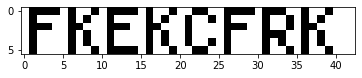

In [12]:
def show(ship):
    real = [int(i.real) for i in ship.keys()]  # get real compontents
    imag = [int(i.imag) for i in ship.keys()]  # get imag components
    minr, maxr, mini, maxi = min(real), max(real), min(imag), max(imag)  # get ranges
    arr = np.zeros((maxr-minr+1, maxi-mini+1))  # create canvas with enough size
    for pos, col in ship.items():
        x, y = pos.real - minr, pos.imag - mini
        arr[int(x),int(y)] = col
    plt.imshow(np.rot90(arr), cmap="Greys")

show(paint_ship(data, WHITE))